# **USING DENSENET FOR TRAINING A MODEL CAPABLE OF TUMOR CLASSIFICATION**


DenseNet (Densely Connected Convolutional Networks) is a type of convolutional neural network architecture designed to improve information flow between layers. Unlike traditional networks where each layer only connects to the next one, DenseNet connects each layer to every other layer in a feed-forward fashion.

Key Points:

1_Dense connections: Each layer receives input from all previous layers and passes its own feature maps to all subsequent layers.

2_Feature reuse: Because of these dense connections, features learned by earlier layers are reused in later layers, which helps with better gradient flow and reduces the risk of vanishing gradients.

3_Efficient parameter use: DenseNet requires fewer parameters compared to traditional CNNs because it doesn’t need to relearn redundant features.

4_Improved performance: It often achieves better accuracy and convergence speed on image classification tasks.

## Importing Necessary Libraries and Installing Dependencies


In [1]:
# Data handling
import pandas as pd
import os
import shutil

# Image processing
from PIL import Image
import torchvision.transforms as T
from torchvision import transforms, models, datasets

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

# Utilities
from tqdm import tqdm
import matplotlib.pyplot as plt

# Machine learning metrics and data splitting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold

# Install required packages
!pip install transformers datasets torchvision tqdm scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Mounting Google Drive in Google Colab


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Load CSV Files and Create Labels for Lung Dataset


In [3]:
# Set the base directory path on Google Drive
base_dir = "/content/drive/MyDrive/lung3.v1-3.multiclass"

# Paths to the train and test CSV files
train_csv_path = os.path.join(base_dir, "train", "_classes.csv")
test_csv_path = os.path.join(base_dir, "test", "_classes.csv")

# Load CSV files into pandas DataFrames
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Show a sample of the training data
print("Train CSV sample:")
print(train_df.head())

# Function to create a label based on benign/malignant flags
def make_label(row):
    if row['benign'] == 1:
        return "benign"
    elif row['malignant'] == 1:
        return "malignant"
    else:
        return "unknown"

# Apply the label function to train and test data
train_df['label'] = train_df.apply(make_label, axis=1)
test_df['label'] = test_df.apply(make_label, axis=1)

# Display label distribution in train and test sets
print("\nLabels distribution in train:")
print(train_df['label'].value_counts())

print("\nLabels distribution in test:")
print(test_df['label'].value_counts())


Train CSV sample:
                                            filename  benign  malignant
0  JPCLN139_png_jpg.rf.60f1dd044d53ee16aa82b7c144...       1          0
1  JPCLN013_png_jpg.rf.b87ef704117ee54f43e0b95bae...       1          0
2  JPCLN067_png_jpg.rf.bda3dbb7c19ab64a2b75cda0ab...       0          1
3  JPCLN013_png_jpg.rf.832ef05a74ae074006daeadbff...       1          0
4  JPCLN111_png_jpg.rf.54682d30bc3e2d9e8c304d1dcf...       1          0

Labels distribution in train:
label
malignant    988
benign       458
Name: count, dtype: int64

Labels distribution in test:
label
malignant    84
benign       39
Name: count, dtype: int64


# Sample Images from Training Dataset with Labels

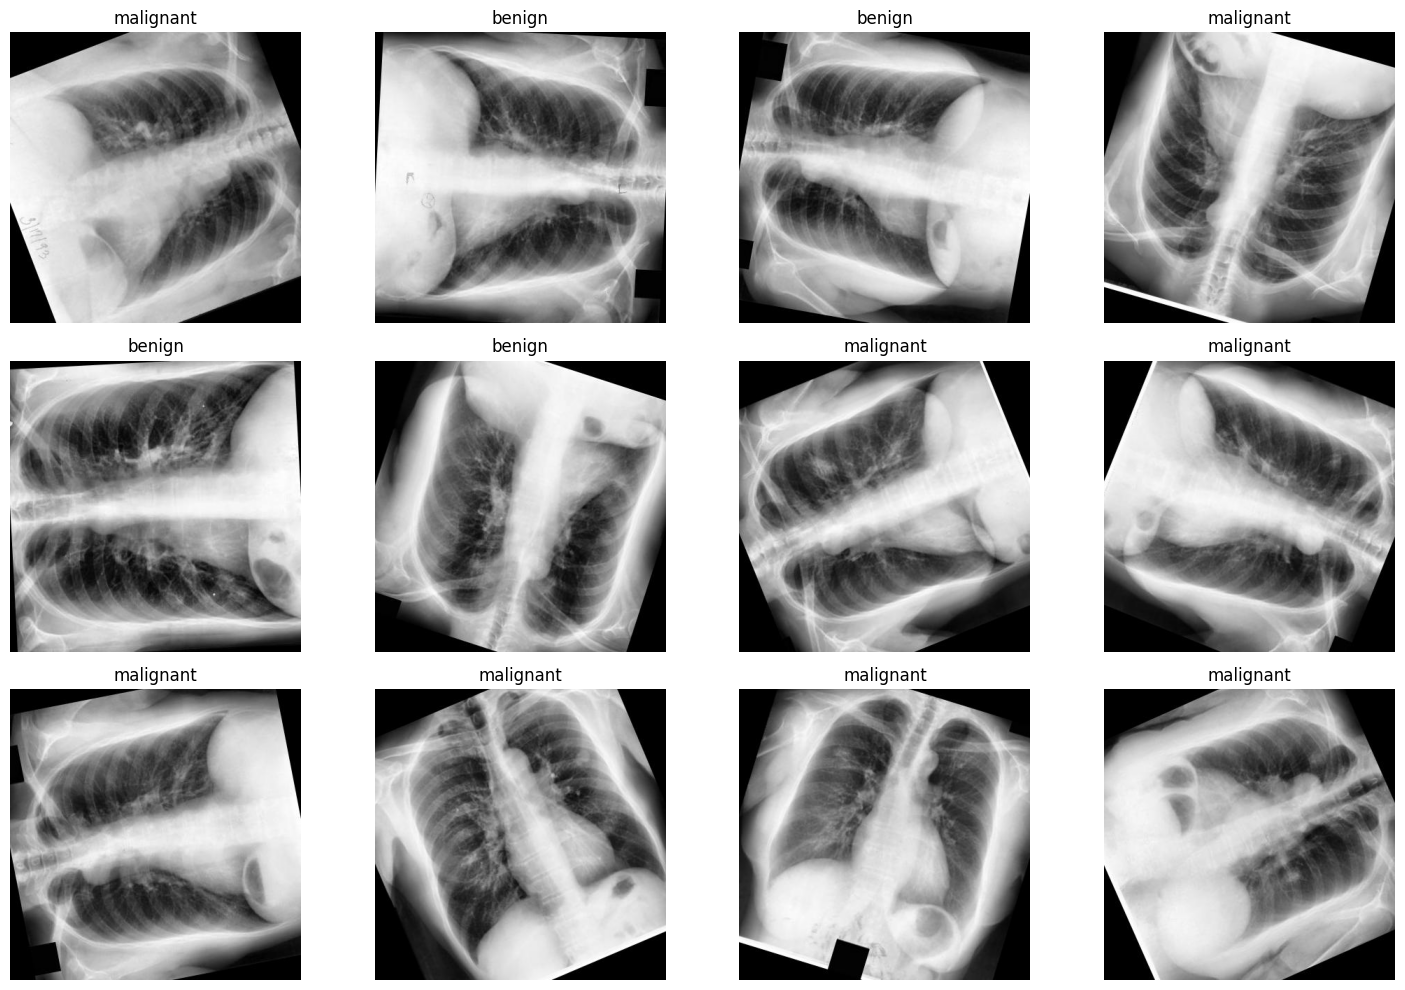

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the path to the training images directory
train_dir = os.path.join(base_dir, "train")

# Function to display a grid of sample images with their corresponding labels
def show_sample_images(df, image_dir, num_images=12):
    sample_df = df.sample(num_images)
    plt.figure(figsize=(15, 10))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, row['filename'])
        image = Image.open(img_path)

        plt.subplot(3, 4, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(row['label'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Execute the function to show sample images
show_sample_images(train_df, train_dir, num_images=12)


## Set Device for PyTorch (GPU if available, otherwise CPU)


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


## Set Paths for Original and Augmented Training Data


In [8]:
original_train_dir = os.path.join(base_dir, "train")
augmented_dir = os.path.join(base_dir, "train_augmented")
os.makedirs(augmented_dir, exist_ok=True)


## Copy Original Training Images to Augmented Directory


In [11]:
# Set path to original training images
original_train_dir = os.path.join(base_dir, "train")

# Copy each training image file to the augmented images folder
for fname in tqdm(train_df['filename']):
    src = os.path.join(original_train_dir, fname)
    dst = os.path.join(augmented_dir, fname)
    shutil.copy(src, dst)


Progress: 100.00% (1446/1446)


## Define Image Augmentation Pipeline Using torchvision.transforms


In [8]:

augment = T.Compose([
    T.RandomHorizontalFlip(p=1.0),             # Flip image horizontally with 100% probability
    T.RandomRotation(25),                       # Rotate image randomly within ±25 degrees
    T.ColorJitter(brightness=0.3, contrast=0.3),  # Randomly change brightness and contrast
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Crop and resize image to 224x224 with random scale
])


## Augment Benign Images to Balance Dataset Classes


In [9]:
# Make a copy of the training dataframe to add augmented data
df_augmented = train_df.copy()
counter = 0

# Separate benign cases and count malignant cases
benign_df = train_df[train_df['label'] == 'benign']
malignant_count = train_df[train_df['label'] == 'malignant'].shape[0]

# Calculate how many benign images need augmentation to balance classes
needed = malignant_count - benign_df.shape[0]

# Reset index for benign images DataFrame
benign_images = benign_df.reset_index(drop=True)

# Loop to generate augmented benign images until balance is reached
while needed > 0:
    for i in range(len(benign_images)):
        if needed <= 0:
            break

        # Load original benign image
        row = benign_images.iloc[i]
        img_path = os.path.join(original_train_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')

        # Apply augmentation transforms
        aug_img = augment(image)

        # Create a new filename for the augmented image
        new_filename = f"aug_benign_{counter}_{row['filename']}"
        aug_img.save(os.path.join(augmented_dir, new_filename))

        # Add augmented image info to dataframe
        df_augmented = pd.concat([df_augmented, pd.DataFrame([{
            'filename': new_filename,
            'benign': 1,
            'malignant': 0,
            'label': 'benign'
        }])], ignore_index=True)

        counter += 1
        needed -= 1


## Split Augmented Dataset into Training and Validation Sets with Stratification


In [ ]:

train_df_new, val_df = train_test_split(
    df_augmented,
    test_size=0.25,                # 25% for validation
    stratify=df_augmented['label'],# maintain label proportions
    random_state=42                # for reproducibility
)

# Show label distribution after splitting
print("Train set distribution (after split):")
print(train_df_new['label'].value_counts())

print("\nValidation set distribution:")
print(val_df['label'].value_counts())


## Custom PyTorch Dataset Class for Medical Images

In [13]:
from torch.utils.data import Dataset

class MedicalImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # Initialize dataset with dataframe, image directory, and optional transforms
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        # Return total number of samples
        return len(self.df)

    def __getitem__(self, idx):
        # Get image and label at given index
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')  # Load image in RGB mode

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Map label to numeric: benign=0, malignant=1
        label = 0 if row['label'] == 'benign' else 1

        return image, label


## Define Evaluation Transforms and Set Test Directory


In [15]:
from torchvision import transforms


eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize images to 224x224
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize with mean and std for 3 channels
])


test_dir = os.path.join(base_dir, "test")


## Create Dataset Instances and DataLoaders for Training, Validation, and Testing


In [26]:
# Create dataset objects with corresponding dataframes, image folders, and transformations
train_dataset = MedicalImageDataset(train_df_new, augmented_dir, transform=eval_transforms)
val_dataset = MedicalImageDataset(val_df, augmented_dir, transform=eval_transforms)
test_dataset = MedicalImageDataset(test_df, test_dir, transform=eval_transforms)

# Create DataLoaders for batching and shuffling data during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("✅ All datasets and dataloaders are ready!")


✅ All datasets and dataloaders are ready!


## Load Pretrained DenseNet121 and Modify Classifier for Binary Classification


In [17]:
import torch.nn as nn
from torchvision import models

# Load DenseNet121 pretrained on ImageNet
model = models.densenet121(pretrained=True)

# Get the number of features in the original classifier layer
num_features = model.classifier.in_features

# Replace the classifier with a custom one for binary classification (2 classes)
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(),                     # Activation function
    nn.Dropout(0.5),               # Dropout for regularization
    nn.Linear(512, 2)              # Output layer: 2 classes (benign, malignant)
)




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Loss Function, Optimizer, and Learning Rate Scheduler


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


## Define Training Loop with Validation for Multiple Epochs


In [19]:
def train(model, train_loader, val_loader, epochs=20):
    # Lists to store loss and accuracy for each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train, total_train = 0, 0

        # Iterate over training batches with progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()        # Clear previous gradients
            outputs = model(inputs)      # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()              # Backpropagation
            optimizer.step()             # Update weights
            running_loss += loss.item()

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()  # Update learning rate scheduler

        train_accuracy = correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Evaluate on validation set without gradient calculation
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_loss = val_loss / len(val_loader)

        # Save epoch results
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        print(f"Train     - Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
        print(f"Validation- Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies


## Define Model Testing and Evaluation Function


In [20]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Save predictions to CPU numpy array
            all_labels.extend(labels.numpy())

    # Print classification report with precision, recall, f1-score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["benign", "malignant"]))

    # Plot confusion matrix to visualize performance
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant"])
    disp.plot(cmap='Blues')
    plt.show()


## Training the DenseNet121 Model for Medical Image Classification


In [21]:
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, epochs=10)


Epoch 1/10: 100%|██████████| 47/47 [00:24<00:00,  1.94it/s]



Epoch [1/10]
Train     - Loss: 0.5506 | Accuracy: 0.7045
Validation- Loss: 1.4357 | Accuracy: 0.5020



Epoch 2/10: 100%|██████████| 47/47 [00:23<00:00,  1.98it/s]



Epoch [2/10]
Train     - Loss: 0.4785 | Accuracy: 0.7571
Validation- Loss: 0.5359 | Accuracy: 0.7713



Epoch 3/10: 100%|██████████| 47/47 [00:23<00:00,  1.97it/s]



Epoch [3/10]
Train     - Loss: 0.4311 | Accuracy: 0.7888
Validation- Loss: 0.5410 | Accuracy: 0.7834



Epoch 4/10: 100%|██████████| 47/47 [00:23<00:00,  1.96it/s]



Epoch [4/10]
Train     - Loss: 0.3170 | Accuracy: 0.8502
Validation- Loss: 0.3161 | Accuracy: 0.8482



Epoch 5/10: 100%|██████████| 47/47 [00:23<00:00,  1.99it/s]



Epoch [5/10]
Train     - Loss: 0.2118 | Accuracy: 0.9211
Validation- Loss: 0.2517 | Accuracy: 0.8785



Epoch 6/10: 100%|██████████| 47/47 [00:23<00:00,  1.98it/s]



Epoch [6/10]
Train     - Loss: 0.1337 | Accuracy: 0.9514
Validation- Loss: 0.2357 | Accuracy: 0.8806



Epoch 7/10: 100%|██████████| 47/47 [00:23<00:00,  1.98it/s]



Epoch [7/10]
Train     - Loss: 0.0860 | Accuracy: 0.9710
Validation- Loss: 0.2252 | Accuracy: 0.9109



Epoch 8/10: 100%|██████████| 47/47 [00:23<00:00,  1.97it/s]



Epoch [8/10]
Train     - Loss: 0.0667 | Accuracy: 0.9811
Validation- Loss: 0.1981 | Accuracy: 0.9170



Epoch 9/10: 100%|██████████| 47/47 [00:23<00:00,  1.96it/s]



Epoch [9/10]
Train     - Loss: 0.0712 | Accuracy: 0.9777
Validation- Loss: 0.1895 | Accuracy: 0.9211



Epoch 10/10: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]



Epoch [10/10]
Train     - Loss: 0.0414 | Accuracy: 0.9933
Validation- Loss: 0.1807 | Accuracy: 0.9312



## Stratified K-Fold Cross Validation on the Test Set


In [51]:
## Stratified K-Fold Cross Validation on the Test Set

K = 10  # Number of folds

labels = test_df['label'].values
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

accuracies = []  # List to store accuracy for each fold

for fold, (train_idx, test_idx) in enumerate(skf.split(test_df, labels)):
    print(f"\nFold {fold + 1}/{K}")

    # Prepare test subset for this fold
    fold_test_df = test_df.iloc[test_idx].reset_index(drop=True)
    fold_test_dataset = MedicalImageDataset(fold_test_df, test_dir, transform=eval_transforms)
    fold_test_loader = DataLoader(fold_test_dataset, batch_size=8, shuffle=False)

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in fold_test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    accuracies.append(acc)
    report = classification_report(all_labels, all_preds, target_names=['benign', 'malignant'])

    print(f"Accuracy for fold {fold + 1}: {acc:.4f}")
    print(report)

# Print average accuracy
print(f"\nAverage Accuracy over {K} folds: {sum(accuracies) / len(accuracies):.4f}")


🔁 Fold 1/10
✅ Accuracy for fold 1: 0.8800
              precision    recall  f1-score   support

      benign       1.00      0.65      0.79         4
   malignant       0.89      1.00      0.94         8

    accuracy                           0.91        12
   macro avg       0.82      0.82      0.87        12
weighted avg       0.90      0.88      0.89        12


🔁 Fold 2/10
✅ Accuracy for fold 2: 0.8700
              precision    recall  f1-score   support

      benign       0.98      0.68      0.80         4
   malignant       0.88      0.99      0.93         8

    accuracy                           0.90        12
   macro avg       0.83      0.83      0.87        12
weighted avg       0.89      0.87      0.88        12


🔁 Fold 3/10
✅ Accuracy for fold 3: 0.8900
              precision    recall  f1-score   support

      benign       1.00      0.70      0.82         4
   malignant       0.90      1.00      0.95         8

    accuracy                           0.92        12


## Training and Validation Curves

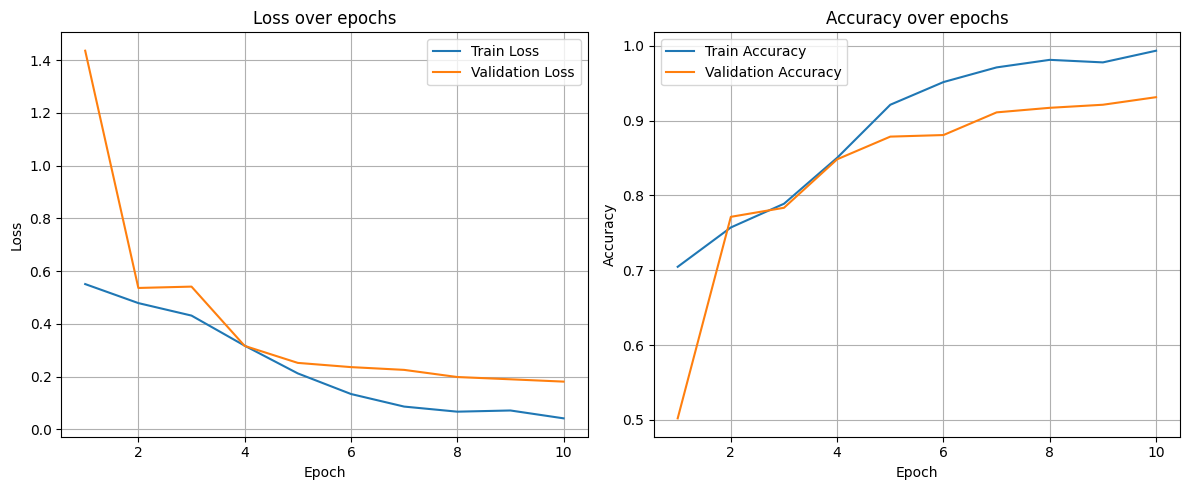

In [47]:


epochs = range(1, 11)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, '-', label='Train Loss')
plt.plot(epochs, val_losses, '-', label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, '-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, '-', label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##  Saving the Trained Model to Google Drive

In [ ]:

save_path = "/content/drive/MyDrive/my_models/"

os.makedirs(save_path, exist_ok=True)
torch.save(model, os.path.join(save_path, "model.pth"))

torch.save(model.state_dict(), os.path.join(save_path, "model_weights.pth"))